# Secular Resonance Hamiltonian Contours
This notebook demonstrates how to genrate a surface of section on a set of initial conditions with constant ${\cal J}$. We'll set up the surface of section to illustrate a secular resonance around $\frac{\partial H_{0}}{\partial {\cal J}_*}= \Omega_\text{sec}\approx 0$.

## Set-up 
The cells below import the packages and functions we'll need and get an `IntegrableResonanceModel` object

In [1]:
import numpy as np
import sys
sys.path+=['../']
from IntegrableResonanceModel import IntegrableResonanceModel
from IntegrableModelUtils import calc_action_and_frequencies
from scipy.optimize import root_scalar
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
%matplotlib inline

/Users/shadden/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#**** Note *******
# Computing accurate secular frequencies can
# require increasing the number of quadrature points
# above the default
res_model = IntegrableResonanceModel(3,1,n_quad_pts=61)

## Parameters of contour plot

Planet masses

In [3]:
res_model.m1 = 3e-5
res_model.m2 = 3e-5

Resonance

In [4]:
res_model.j = 3
res_model.k = 1

Specify the ${\cal J}^*$ value on which the resonance will be centered by defining  the corresponding value of eccentricity as $Z_0/Z_{cross}=$ `zf0` . This sets 
$${\cal J}^* = \frac{f^2+g^2}{{\tilde f}^2+{\tilde g}^2}Z_0^2$$
by analogy with the relationship between $J$ and $Z$ given in Equation 20. 

In [5]:
zf0 = 0.25 

Specify the value of ${\cal A}$ such that ${\cal A}={\cal J}^*$ for $Z_{0}/Z_\text{cross}=$ `zf_max`

In [6]:
zf_max = 0.5 

## Locate secular resonance
We'll start by finding the ${\cal J}$ value that corresponds to the nominal location of secular resonance at a the user-specified value of ${\cal J}^*$.
The resonance location is found by calculating the secular frequency as a function of intial libration amplitude and using root-finding to locate the libration amplitude for which $\Omega_\text{sec} =0$

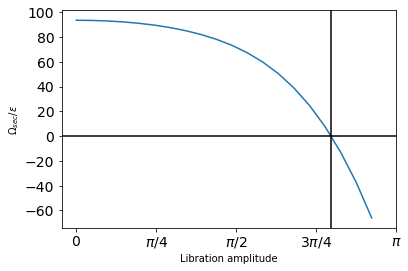

In [28]:
_,_,Z = res_model.get_z1z2Z_from_zfrac(zf0) # convert 'zf' to Z
Jstar = res_model.Zsq_to_J * (Z)**2 # convert Z to a value of Jstar

yell = res_model.elliptic_fixed_point(Jstar) # find elliptic point
yunst = res_model.unstable_fixed_point(Jstar) # find unstable fixed point

# Get secular coefficients 
a_s,b_s,c_s = res_model.secular_coeffs()
eps_bs = b_s * res_model.eps

# Calculate initial conditions for a given libration amplitude
calc_ics = lambda librationAmplitude:  yell + (yunst-yell) * librationAmplitude / np.pi 

# Calculate the secular frequency as a function of libration amplitude
#  Note: The correction '\epsilon \times b_s' to Omega_sec added by H_pert
#     is included explicitly since 'calc_action_and_frequencies' does not 
#     account for H_pert 
calc_Omega_sec = lambda librationAmplitude: eps_bs + calc_action_and_frequencies(
    calc_ics(librationAmplitude),
    res_model)[2]

# Find libration amplitude where Omega_sec = 0 
root = root_scalar(calc_Omega_sec,bracket=[2.,2.7])

# Store value of action of the resonant trajectory
ics0 = calc_ics(root.root)
action0,_,Osec=calc_action_and_frequencies(ics0,res_model)

assert(np.isclose(Osec+eps_bs,0)), "Root-finding did not locate Omega_sec = 0!"

amp = np.linspace(0,2.9,20)
plt.plot(amp,[calc_Omega_sec(a)/res_model.eps for a in amp])
plt.axvline(root.root,color='k')
plt.axhline(0,color='k')
plt.xticks(
    [0,np.pi/4,np.pi/2,0.75*np.pi,np.pi],
    [r"$0$",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"],
    fontsize=14
);
plt.yticks(fontsize=14)
plt.xlabel("Libration amplitude")
plt.ylabel(r"$\Omega_{sec} / \epsilon$")

## Generate initial conditions 
Solve for initial condtions with the same value of ${\cal J}=$`action0` at different values of ${\cal J}^*$.

First we'll search for the value of ${\cal J}^*$ for which the trajectory with adiabatic invariant ${\cal J}$ has a libration amplitude equal to `max_amp`. 
This will define the minimum value for our range of ${\cal J}^*$ values.
The maximum value of our range of ${\cal J}^*$ values has been specified above as `zf_max`.

In [ ]:
# Determine minimum zf by setting maximum libration amplitude
max_amp=2.9

In [8]:
def calc_action_vs_zf_and_amp(zf,amp,res_model,get_ic=False):
    _,_,Z = res_model.get_z1z2Z_from_zfrac(zf) # convert 'zf' to Z
    Jstar = res_model.Zsq_to_J * (Z)**2 # convert Z to a value of Jstar
    yell = res_model.elliptic_fixed_point(Jstar) # find elliptic point
    yunst = res_model.unstable_fixed_point(Jstar) # find unstable fixed point
    ic = yell + (yunst-yell) * amp / np.pi 
    if get_ic:
        return ic
    return calc_action_and_frequencies(ic,res_model)[0]

In [9]:
assert max_amp >= root.root, "Max libraiton amplitude should be set larger than amplitude found at the resonance location."
root_zfmin = root_scalar(
    lambda zf: calc_action_vs_zf_and_amp(zf,max_amp,res_model)-action0,
    bracket=[0.15,zf0]
)
ic_root = calc_action_vs_zf_and_amp(
    root_zfmin.root,
    max_amp,
    res_model,get_ic=True
)
assert np.isclose(calc_action_and_frequencies(ic_root,res_model)[0] ,action0), "Root-finding failed"

 For each `zf` in our range, we'll determine the libration amplitude that gives us $\cal J$=`action0`

In [10]:
# 'zf_min' and 'zf_max' define the range of 
# J_star values over which to generate initial conditions

zf_min=root_zfmin.root
zfs = np.linspace(zf_min,zf_max,16)

ics = []
for i,zf in enumerate(zfs):
    if i==0:
        ics.append(ic_root)
        root_last = max_amp
        continue
    _,_,Z = res_model.get_z1z2Z_from_zfrac(zf)
    Jstar = res_model.Zsq_to_J * (Z)**2
    yell = res_model.elliptic_fixed_point(Jstar)
    yunst = res_model.unstable_fixed_point(Jstar) 
    
    # Calculate initial conditions for a given libration amplitude
    calc_ics = lambda librationAmplitude:  yell + (yunst-yell) * librationAmplitude / np.pi
    
    # Calculate value of action as function of libration amplitude
    calc_action = lambda librationAmplitude: calc_action_and_frequencies(calc_ics(librationAmplitude),res_model)[0]
    
    # Calculate difference from target value of action as function of libration amplitude
    calc_delta_action = lambda librationAmplitude: calc_action(librationAmplitude)-action0
    
    try:
        root = root_scalar(calc_delta_action,bracket=[1,root_last])
        
    except ValueError:
        print("Failed for zf ={:.2f}. Try changing the bracketing values for the root.".format(zf))
        break
    if root.converged:
        ics.append(calc_ics(root.root))
        root_last = root.root
    else:
        print("Failed for zf ={:.2f}. Root did not converge.".format(zf))
ics = np.array(ics)

 We interpolate our results above to generate intial conditions  at constant ${\cal J}$ as a function of ${Z_0}/Z_{cross}$

In [11]:
ics_vs_zfrac = CubicSpline(zfs,ics)

A quick look at the set of initial conditions we've generated

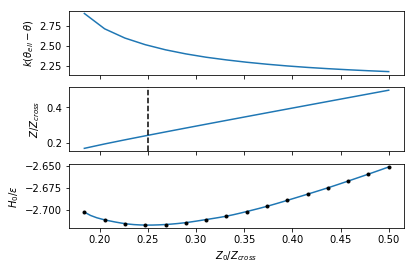

In [12]:
_,_,Zcross = res_model.get_z1z2Z_from_zfrac(1)
JtoZfrac = lambda J: np.sqrt(J/res_model.Zsq_to_J) / Zcross
fig,ax = plt.subplots(3,sharex=True)
ax[0].plot(JtoZfrac(ics[:,3]) , res_model.k * (yell[0]-ics[:,0]) )
ax[1].plot(JtoZfrac(ics[:,3]) , JtoZfrac(ics[:,2]))
ax[0].set_ylabel(r"$k(\theta_{ell}-\theta)$")
ax[1].set_ylabel(r"$Z/Z_{cross}$")
ax[1].axvline(zf0,color='k',ls='--')
_x = np.linspace(zf_min,zf_max)
ax[2].plot(_x,[res_model.H(ics_vs_zfrac(zf))/res_model.eps for zf in _x])
ax[2].plot(zfs,[res_model.H(ics_vs_zfrac(zf))/res_model.eps for zf in zfs],'k.')
ax[2].set_xlabel(r"$Z_0/Z_{cross}$")
ax[2].set_ylabel(r"$H_{0}/\epsilon$")

#  Creating the contour plot 

We'll plot contours of the Hamiltonian
$$
\bar{H}(\zeta^*,{\cal J^*};{\cal A},{\cal J}) = H_{0}({\cal J},{\cal J^*}) +  \epsilon b_s J^* -\epsilon c_s ({\cal A} - {\cal J^*})^{1/2} F_0\cos(\zeta^*)
$$
where
$$
F_0({\cal J},{\cal J^*}) = \int_{0}^{2\pi}\sqrt{J}\cos[\theta-\rho(\zeta)]d\zeta~.
$$
We'll plot contours as a function of variables $({Z_0}/Z_\text{cross},\theta+\theta^*)$ with ${\cal J}=$`action0` held fixed.

In [89]:
def F0_integrand(t,soln,Omega_sec):
    y = soln(t)
    J = y[2]
    theta = y[0]
    theta_star = y[1]
    return np.sqrt(J) * np.exp(1j * (theta + theta_star - Omega_sec * t ) )

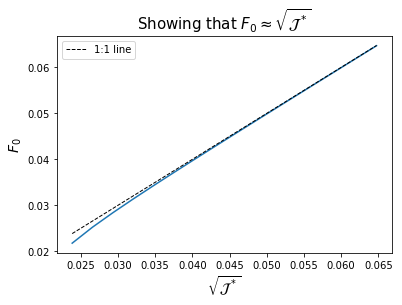

In [90]:
F0 = []
_nodes,_weights=np.polynomial.legendre.leggauss(61)
for ic in ics:
    _,Ores,Osec,soln = calc_action_and_frequencies(ic,res_model,return_solution=True)
    tmin,tmax = soln.sol.t_min,soln.sol.t_max
    nodes = _nodes * (tmax - tmin) * 0.5 + (tmax+tmin) * 0.5 
    weights = _weights *  0.5
    F0.append(weights.dot(F0_integrand(nodes,soln.sol,Osec)))

F0_vs_zfrac = CubicSpline(zfs,F0)

plt.plot(np.sqrt(ics_vs_zfrac(zfs)[:,3]),np.abs(F0_vs_zfrac(zfs) ))
plt.plot(np.sqrt(ics_vs_zfrac(zfs)[:,3]),np.sqrt(ics_vs_zfrac(zfs)[:,3]) ,'k--',lw=1,label="1:1 line")
plt.legend()
plt.title(r"Showing that $F_0\approx \sqrt{{\cal J}^*}$",fontsize=15)
plt.xlabel(r"$\sqrt{{\cal J}^*}$",fontsize=14)
plt.ylabel(r"$F_0$",fontsize=14)

In [17]:
# Set calA as the max value of J^*.
# Note that calA *must* be greater than or equal to J^*
calA = ics_vs_zfrac(zf_max)[3]
_,b_s,c_s = res_model.secular_coeffs()

# set up grid
Ngrid = 60
Energy = np.zeros((Ngrid,Ngrid))
grid_zfs = np.linspace(zf_min,zf_max,Ngrid)
theta_plus_thetastars = np.linspace(-np.pi,np.pi,Ngrid)
eps = res_model.eps

# loop over grid
for i,zf in enumerate(grid_zfs):
    Fc  = np.abs(F0_vs_zfrac(zf))
    for j,theta_plus_thetastar in enumerate(theta_plus_thetastars):
        y = ics_vs_zfrac(zf)
        y[1] = theta_plus_thetastar - y[0]
        J_star = y[3]
        Energy[i,j] = res_model.H(y) + eps * b_s * J_star - eps * c_s * np.sqrt(calA-J_star) * Fc * np.cos(theta_plus_thetastar)



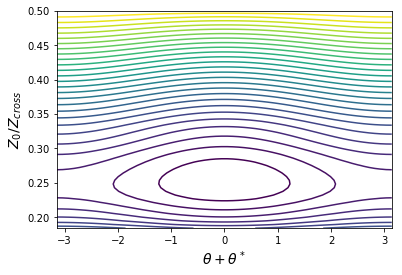

In [18]:
X,Y = np.meshgrid(theta_plus_thetastars,grid_zfs)
plt.contour(X,Y,Energy,30)
plt.xlabel(r"$\theta+\theta^*$",fontsize=14)
plt.ylabel(r"$Z_0/Z_{cross}$",fontsize=14)

# Compare to $N$-body
  Let's run a few $N$-body simulations to compare with our surface of section.

In [19]:
# Initial Z0/Zcross values to use
Nb_zfs = np.linspace(zf_min,0.35,5)

# Initial theta+theta_star value to use
initial_theta_plus_theta_star = 0

# Lists to store rebound simlutions 
sims = []

# Set up sims
for zf in Nb_zfs:
    y = ics_vs_zfrac(zf)
    y[1] = initial_theta_plus_theta_star - y[0]
    J_star = y[3]
    sims.append(res_model.dyvars_to_rebound_sim(y,calA = calA,P2 = 2*np.pi))

In [20]:
# Integration times
time = np.linspace(0, 1.5e4 * sims[0].particles[2].P,350)

In [21]:
# Run integrations, store orbital elements
els = np.zeros((len(sims),len(time),2,4))
for i,t in enumerate(time):
    for k,sim in enumerate(sims):
        sim.integrate(t)
        for j,p in enumerate(sim.particles[1:]):
            els[k,i,j] = p.P,p.e,p.l,p.pomega

# Create plots

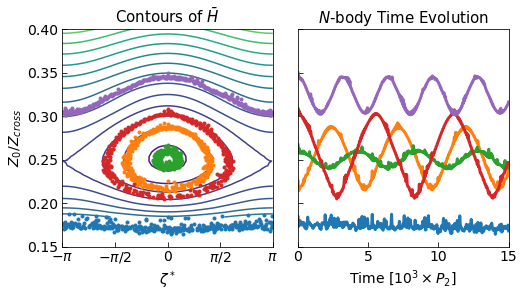

In [32]:
fig,ax = plt.subplots(1,2,figsize=(8,4),sharey=True)
ax = [_ for _ in reversed(ax)]
_,_,Zcross = res_model.get_z1z2Z_from_zfrac(1)
X,Y = np.meshgrid(theta_plus_thetastars,grid_zfs)

# Set the energy level contours to plot
# This may require some fiddling to get a pretty plot
contour_levels =  []
for zf in np.linspace(zf0,0.45,20):
    y = ics_vs_zfrac(zf)
    y[1] = theta_plus_thetastar - y[0]
    J_star = y[3]
    E = res_model.H(y) + eps * b_s * J_star - eps * c_s * np.sqrt(calA-J_star) * Fc
    contour_levels.append(E)

# Energy level contours
ax[1].contour(X,Y,Energy, contour_levels)

for k in range(len(sims)):
    z1,z2 = np.transpose(els[k,:,:,1] * np.exp(1j * els[k,:,:,3]))
    Mmtrx = res_model._get_M_matrix()
    rtPhi_exp_iphi,rtPsi_exp_ipsi = np.conjugate(np.linalg.inv(Mmtrx).dot([z1,z2]))
    J = np.abs(rtPhi_exp_iphi)**2
    l1,l2=np.transpose(els[k,:,:,2])
    P1,P2=np.transpose(els[k,:,:,0])
    Delta = (res_model.j - res_model.k) * P2 / P1 / res_model.j - 1
    Jstar = J-Delta / res_model.dJ_to_Delta
    Q = res_model.j * l2 - (res_model.j-res_model.k) * l1
    theta = (Q + res_model.k * np.angle(rtPhi_exp_iphi)) / res_model.k
    thetaStar = -1 * (Q + res_model.k * np.angle(rtPsi_exp_ipsi)) / res_model.k
    
    # Plot Z / Zcross and Z_0 / Zcross versus time
    Z0_over_Zcross = np.sqrt(Jstar/res_model.Zsq_to_J)/Zcross
    Z_over_Zcross = np.sqrt(J/res_model.Zsq_to_J)/Zcross
    line,=ax[0].plot(time/(1e3 * 2*np.pi),Z0_over_Zcross,lw = 3)
    #ax[0].plot(time,Z_over_Zcross,'--',color=line.get_color(),lw=1,alpha=0.5)
    
    # Plot Z_0 / Zcross versus theta+thetaStar on the surface of section plot
    ang = np.mod(theta+thetaStar+np.pi,2*np.pi)-np.pi
    ax[1].plot(ang,Z0_over_Zcross,'.',color=line.get_color())


ax[0].set_xlabel(r"Time [$10^3\times P_2$]",fontsize=14)
#ax[0].set_ylabel(r"$Z_0/Z_{cross}$",fontsize=14)
ax[0].set_xlim(0,time[-1]/(1e3 * 2*np.pi))
ax[0].set_title(r"$N$-body Time Evolution",fontsize=15)
ax[0].set_xticks(
    5 * np.arange(0,4)
    );

for a in ax:
    a.xaxis.set_tick_params(labelsize=14,direction='in',size=5)
    a.yaxis.set_tick_params(labelsize=14,direction='in',size=5)



ax[1].set_title(r"Contours of ${\bar H}$",fontsize=15)
ax[1].set_xlabel(r"$\zeta^*$",fontsize=14)
ax[1].set_ylabel(r"$Z_0/Z_{cross}$",fontsize=14)
#ax[1].set_ylim(0.2,0.6);
ax[1].set_xticks(
    [-np.pi,-np.pi/2,0,np.pi/2,np.pi],
    );
ax[1].set_xticklabels([r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"],fontsize=14);
ax[1].set_ylim(0.15,0.4)
plt.subplots_adjust(wspace=0.12)

plt.savefig(
    "/Users/shadden/DropboxSmithsonian/Apps/ShareLaTeX/Resonance/secular_sos_{}to{}_zf0_0p{}_A_0p{}.pdf".format(
    res_model.j,res_model.j - res_model.k,int(100 * zf0),int(100 * zf_max)
    ),
    bbox_inches='tight'
)


Pretty good agreement! Some possible sources of disagreement:
- We should really section our $N$-body points properly, e.g. recording points every time $\theta(\zeta)=0$ instead of plotting output at arbitarily spaced times. Alternatively, we could attempt to correct the action variables by computing $\bar{ {\cal J}}_i = {\cal J}_i + \frac{\partial W}{\partial \zeta_i}$ where $W$ is a generating function that satisfies $$\sum_{i=1}^{2}\Omega_i\frac{\partial W(\zeta_i,{\cal J}_i)}{\partial\zeta_i} =H_\text{pert}(\zeta_i,{\cal J}_i) - \frac{1}{2\pi}\int_{0}^{2\pi} H_\text{pert}(\zeta_i,{\cal J}_i) d\zeta$$
(See <a href=https://ui.adsabs.harvard.edu/abs/1990CeMDA..49...43H/abstract>Henrard (1990)</a> for details, including methods for computing $\bar{ {\cal J}}$ semi-numerically).
- The secular Hamiltonian was truncated at second order in eccentricities.
- For second-order resonance, the average value of the dropped resonant terms $$\left[(fz_1 + gz_2)^2 - \sum_{l=0}^{2}C_{j,2,l}z_1^{l}z_2'^{2-l}\right]e^{-iQ} + c.c.$$
    contribute a small correction to the secular Hamiltonian at second order in eccentricity. Analogous terms should be included for first-order resonances as well (e.g., for a 3:2 resonance, terms from the '6:4 resonance' are implicitly dropped.)


I'll leave it as an exercise to determine which effect is dominant... :)